## Bio-Inspired  Optimization for Hyperparameter Tuning (BACO-HT) in Compressive Strength Prediction

In [1]:
# Importing all the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from scipy import stats

from pyswarm import pso

In [2]:
import pandas as pd

# Load the dataset
file_path = "concrete_data.csv"
df = pd.read_csv(file_path)



In [3]:
# overview of the data
df.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
# Check for duplicate rows
duplicates_df = df[df.duplicated()]

if not duplicates_df.empty:
    print("Duplicates found in the dataset:")
    print(duplicates_df)
else:
    print("No duplicates found in the dataset.")

Duplicates found in the dataset:
     cement  blast_furnace_slag  fly_ash  water  superplasticizer  \
77    425.0               106.3      0.0  153.5              16.5   
80    425.0               106.3      0.0  153.5              16.5   
86    362.6               189.0      0.0  164.9              11.6   
88    362.6               189.0      0.0  164.9              11.6   
91    362.6               189.0      0.0  164.9              11.6   
100   425.0               106.3      0.0  153.5              16.5   
103   425.0               106.3      0.0  153.5              16.5   
109   362.6               189.0      0.0  164.9              11.6   
111   362.6               189.0      0.0  164.9              11.6   
123   425.0               106.3      0.0  153.5              16.5   
126   425.0               106.3      0.0  153.5              16.5   
132   362.6               189.0      0.0  164.9              11.6   
134   362.6               189.0      0.0  164.9              11.6   
1

In [5]:
#remove the duplicates
df = df.drop_duplicates()

In [6]:
# number of rows and cols
df.shape

(1005, 9)

In [8]:
# check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
cement                           0
blast_furnace_slag               0
fly_ash                          0
water                            0
superplasticizer                 0
coarse_aggregate                 0
fine_aggregate                   0
age                              0
concrete_compressive_strength    0
dtype: int64


In [9]:
df.shape

(1005, 9)

In [10]:
# Display summary statistics
print("\nSummary Statistics:")
print(df.describe().transpose())


Summary Statistics:
                                count        mean         std     min     25%  \
cement                         1005.0  278.631343  104.344261  102.00  190.70   
blast_furnace_slag             1005.0   72.043483   86.170807    0.00    0.00   
fly_ash                        1005.0   55.536318   64.207969    0.00    0.00   
water                          1005.0  182.075323   21.339334  121.80  166.60   
superplasticizer               1005.0    6.033234    5.919967    0.00    0.00   
coarse_aggregate               1005.0  974.376816   77.579667  801.00  932.00   
fine_aggregate                 1005.0  772.688259   80.340435  594.00  724.30   
age                            1005.0   45.856716   63.734692    1.00    7.00   
concrete_compressive_strength  1005.0   35.250378   16.284815    2.33   23.52   

                                 50%      75%     max  
cement                         265.0   349.00   540.0  
blast_furnace_slag              20.0   142.50   359.4  


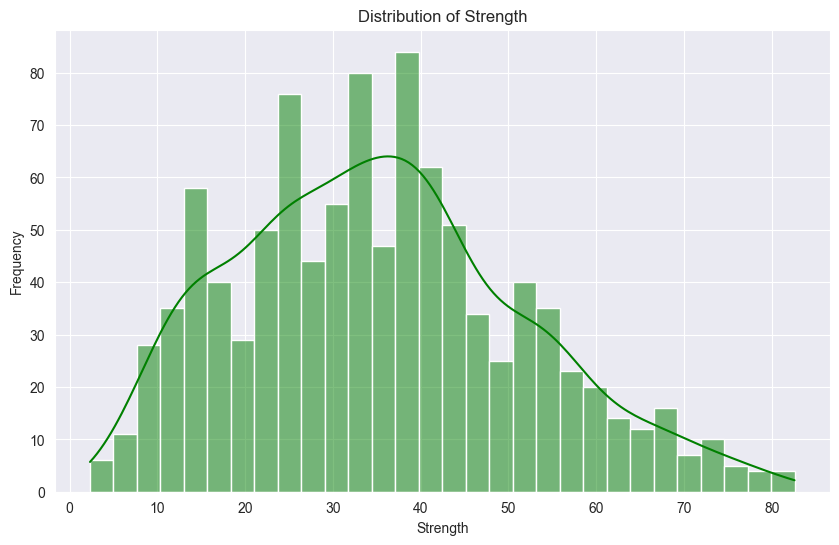

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df['concrete_compressive_strength'], bins=30, kde=True, color='green')
plt.title('Distribution of Strength')
plt.xlabel('Strength')
plt.ylabel('Frequency')
plt.show()

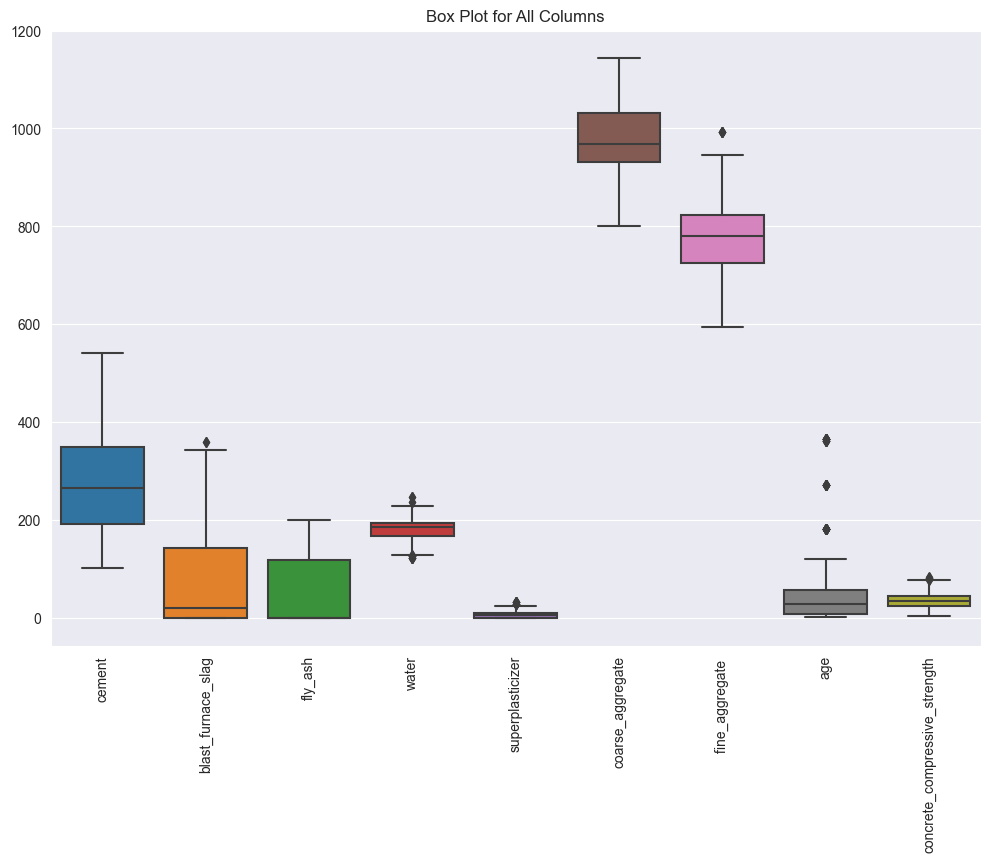

In [12]:
# check for outliers
# Box plots
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Box Plot for All Columns')
plt.show()

In [13]:
print(df.columns)


Index(['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate ', 'age',
       'concrete_compressive_strength'],
      dtype='object')


In [14]:
df.columns = df.columns.str.strip()


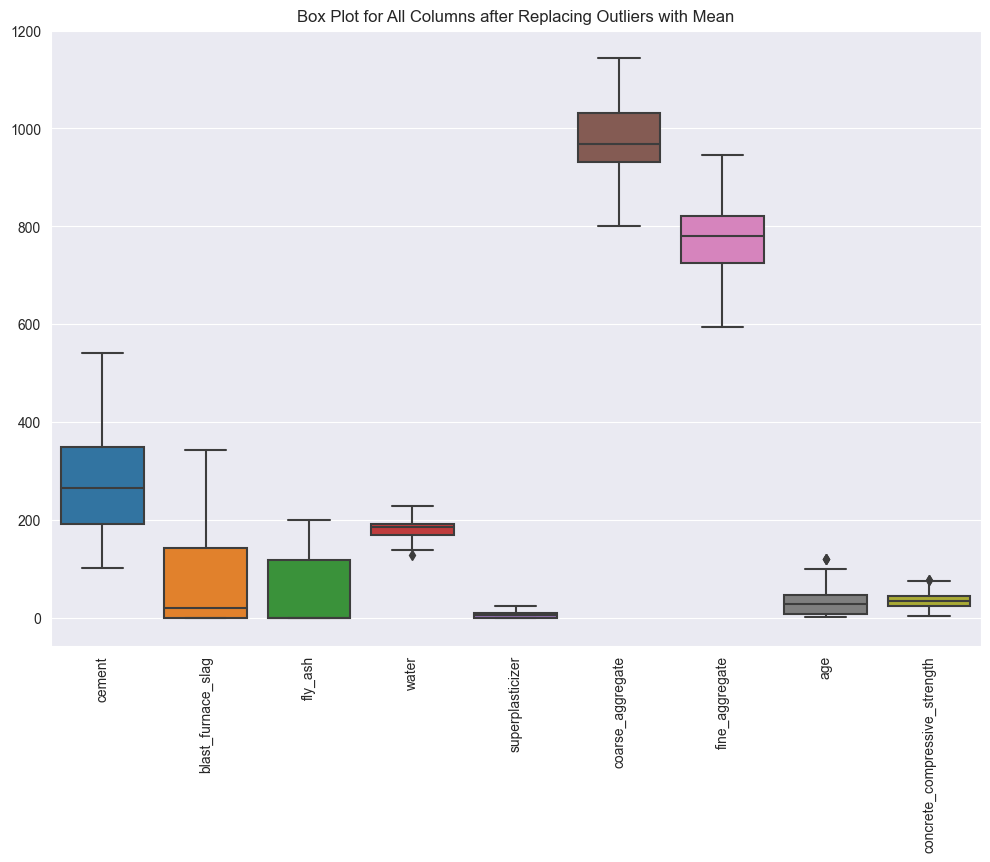

In [15]:
# Replace outliers with mean
def replace_outliers_with_mean(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Creating a copy of the column where outliers are replaced with the mean value
    column_cleaned = column.copy()
    column_cleaned[(column_cleaned < lower_bound) | (column_cleaned > upper_bound)] = column_cleaned.mean()
    return column_cleaned

# Assuming 'df' is your DataFrame
columns_to_replace_outliers = ['blast_furnace_slag', 'water','superplasticizer','fine_aggregate', 'age', 'concrete_compressive_strength']

# Apply the function to the selected columns
df[columns_to_replace_outliers] = df[columns_to_replace_outliers].apply(replace_outliers_with_mean)

# Plot boxplot to show the data after replacing outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Box Plot for All Columns after Replacing Outliers with Mean')
plt.show()

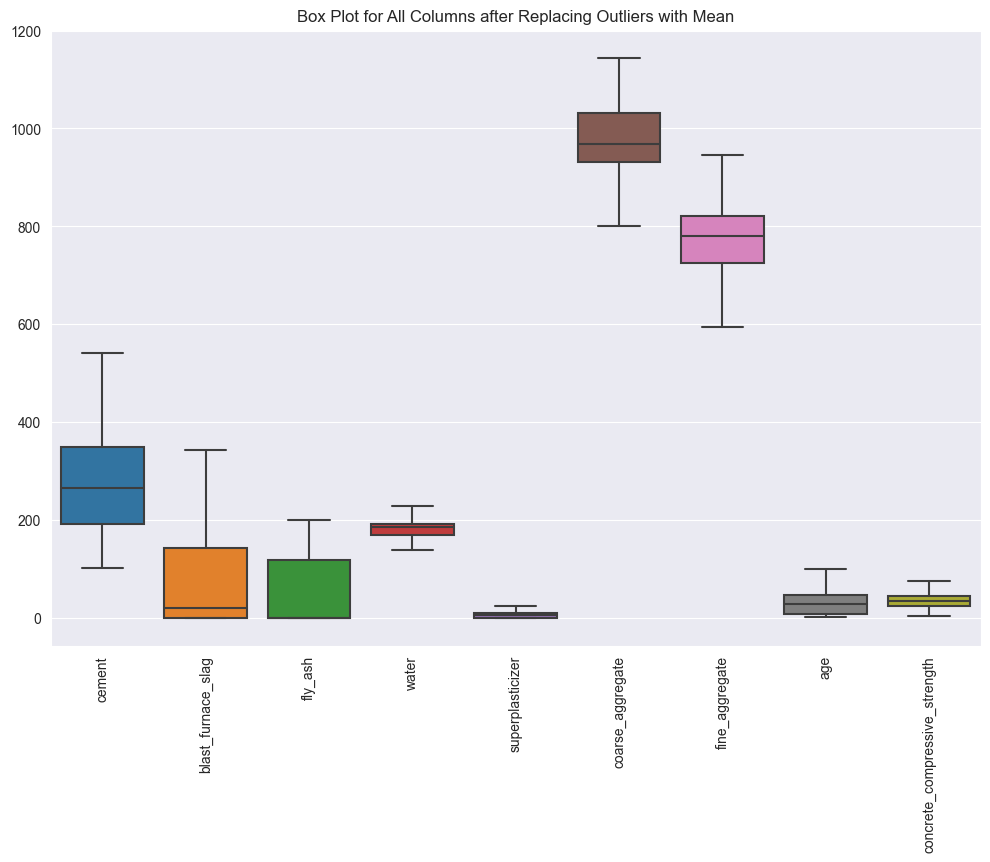

In [16]:
columns_to_replace_outliers = ['water', 'age', 'concrete_compressive_strength']
df[columns_to_replace_outliers] = df[columns_to_replace_outliers].apply(replace_outliers_with_mean)
plt.figure(figsize=(12, 8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title('Box Plot for All Columns after Replacing Outliers with Mean')
plt.show()

### Corr matrix

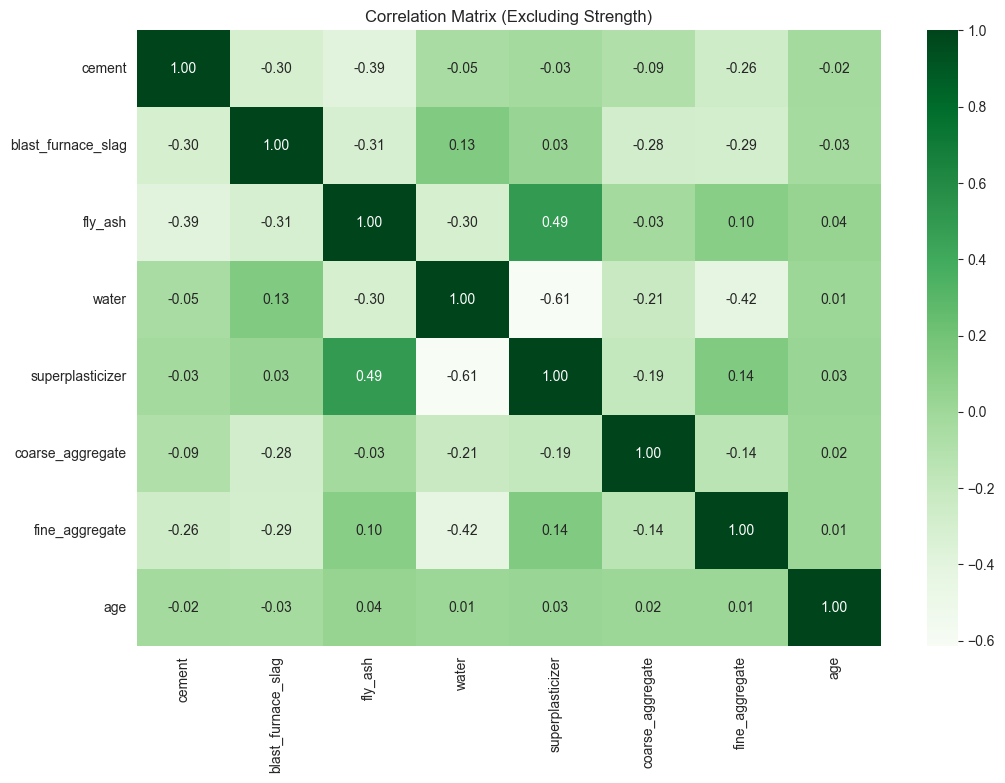

In [17]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.drop('concrete_compressive_strength', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title('Correlation Matrix (Excluding Strength)')
plt.show()

#### Considering the positive correlation between 'Superplasticizer' and 'Fly Ash,' as well as the negative correlations between 'Superplasticizer' and 'Water,' and 'Water' and 'Fine Aggregate,' I opt to remove the variables 'Superplasticizer' and 'Water.'

### This decision aims to address potential multicollinearity concerns and improve the stability of the model.

In [18]:
# Assign predictors and target, removing 'Strength' and 'Superplasticizer'
concrete_data_columns = df.columns
predictors =df.drop(['concrete_compressive_strength', 'superplasticizer', 'water'], axis=1)
target = df['concrete_compressive_strength']

In [19]:
X = df.drop(columns=['concrete_compressive_strength'])
y = df['concrete_compressive_strength']    

In [20]:

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(predictors, target, test_size=0.2, random_state=42)

In [21]:
# Print the number of rows
print("Number of rows in X_train:", X_train.shape[0])
print("Number of rows in X_test:", X_test.shape[0])
print("Number of rows in y_train:", Y_train.shape[0])
print("Number of rows in y_test:", Y_test.shape[0])

Number of rows in X_train: 804
Number of rows in X_test: 201
Number of rows in y_train: 804
Number of rows in y_test: 201


c:\Users\nt465\.conda\envs\testenv\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if sys.path[0] == "":


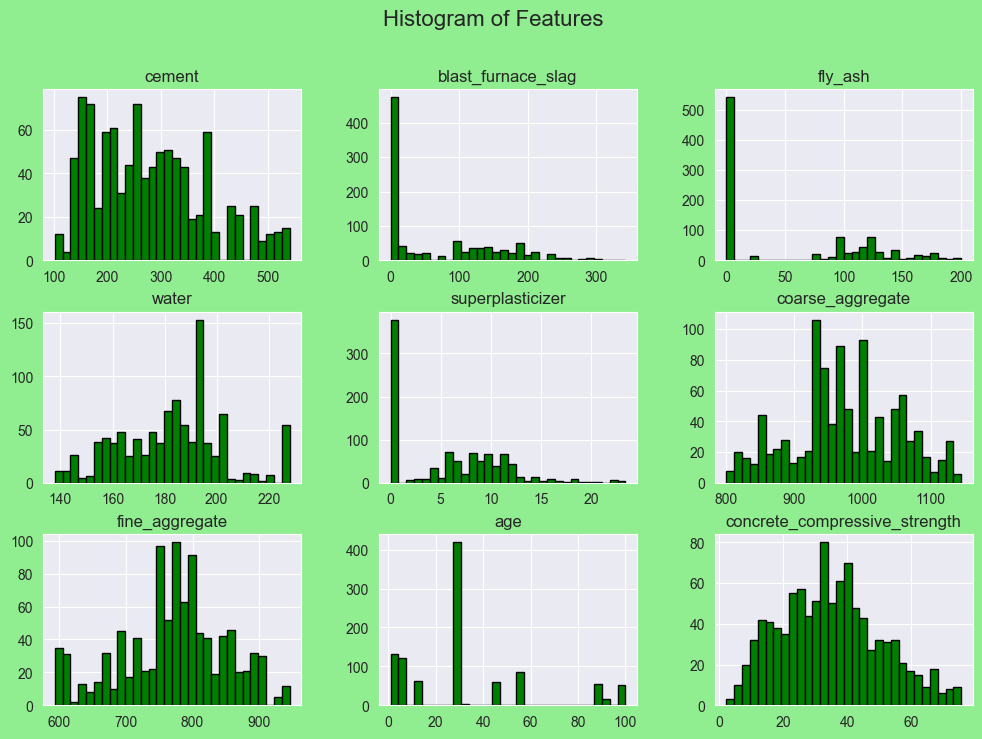

In [22]:
# Set the style for the plot
sns.set_style("darkgrid")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color of the figure and axes
fig.patch.set_facecolor('lightgreen')  # Set figure background to light green
ax.set_facecolor('lightgreen')         # Set axes background to light green

# Plot the histogram with green bars
df.hist(ax=ax, bins=30, edgecolor="black", color="green")

# Add a title to the plot
plt.suptitle("Histogram of Features", fontsize=16)

# Show the plot
plt.show()

Training Set Metrics:
R2 score: 0.9639
MAE: 1.8979
RMSE: 2.9685

Test Set Metrics:
R2 score: 0.8589
MAE: 3.9263
RMSE: 5.9352
Accuracy: 86.46%


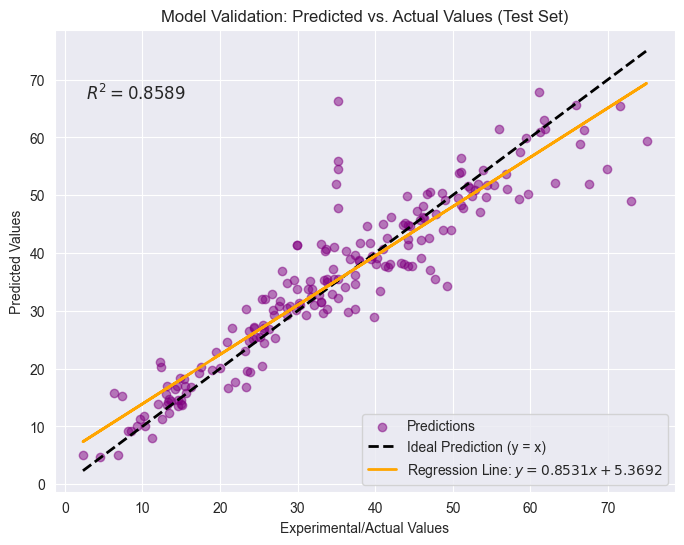

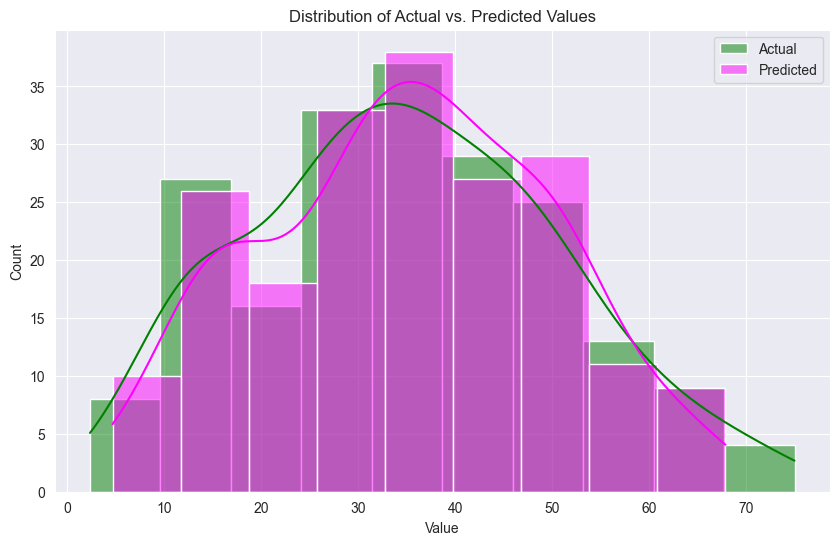

In [23]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split



# Initialize the LightGBM model
model = LGBMRegressor()

# Train the model on the training data
model.fit(X_train, Y_train)

# Make predictions on the training and test sets
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

# Calculate the metrics for the test set
r2_test = r2_score(Y_test, Y_pred_test)
mae_test = mean_absolute_error(Y_test, Y_pred_test)
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
mape_test = mean_absolute_percentage_error(Y_test, Y_pred_test)
accuracy_test = 100 - mape_test * 100 

# Evaluate the model on the training set
print("Training Set Metrics:")
print(f"R2 score: {r2_score(Y_train, Y_pred_train):.4f}")
print(f"MAE: {mean_absolute_error(Y_train, Y_pred_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_train, Y_pred_train)):.4f}")

# Evaluate the model on the test set
print("\nTest Set Metrics:")
print(f"R2 score: {r2_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"Accuracy: {accuracy_test:.2f}%")

# Scatter Plot for Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred_test, alpha=0.5, label='Predictions', color='purple')

# Ideal Prediction Line (y = x)
max_val = max(Y_test.max(), Y_pred_test.max())
min_val = min(Y_test.min(), Y_pred_test.min())
plt.plot([min_val, max_val], [min_val, max_val], '--', lw=2, color='black', label='Ideal Prediction (y = x)')

# Regression Line for Predictions
coefficients = np.polyfit(Y_test, Y_pred_test, 1)
regression_line = np.polyval(coefficients, Y_test)
plt.plot(Y_test, regression_line, color='orange', lw=2, 
         label=f'Regression Line: $y = {coefficients[0]:.4f}x + {coefficients[1]:.4f}$')

# Add R² value to the plot
plt.text(0.05, 0.85, f'$R^2 = {r2_test:.4f}$', transform=plt.gca().transAxes, fontsize=12)

# Labels and title
plt.xlabel('Experimental/Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model Validation: Predicted vs. Actual Values (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(Y_test, color='green', label='Actual', kde=True, alpha=0.5)
sns.histplot(Y_pred_test, color='magenta', label='Predicted', kde=True, alpha=0.5)
plt.xlabel('Value')
plt.title('Distribution of Actual vs. Predicted Values')
plt.legend()
plt.show()


### Random forest regression

Training Set Metrics:
R2 score: 0.9741
MAE: 1.6796
RMSE: 2.5168

Test Set Metrics:
R2 score: 0.8356
MAE: 4.2689
RMSE: 6.4058
Accuracy: 84.90%


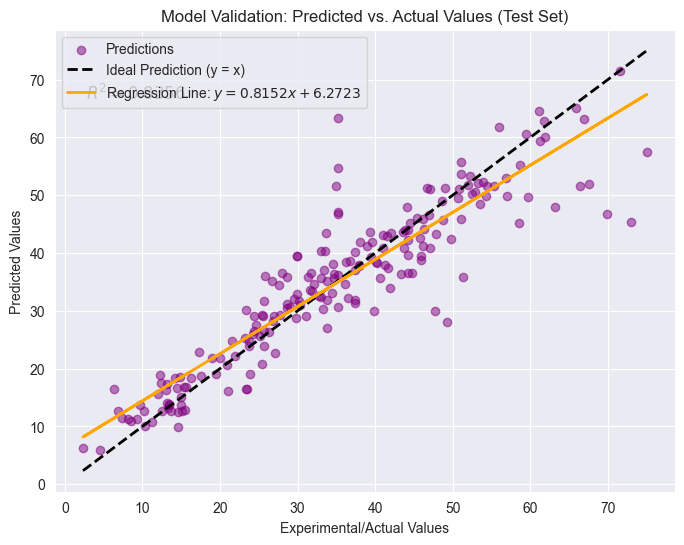

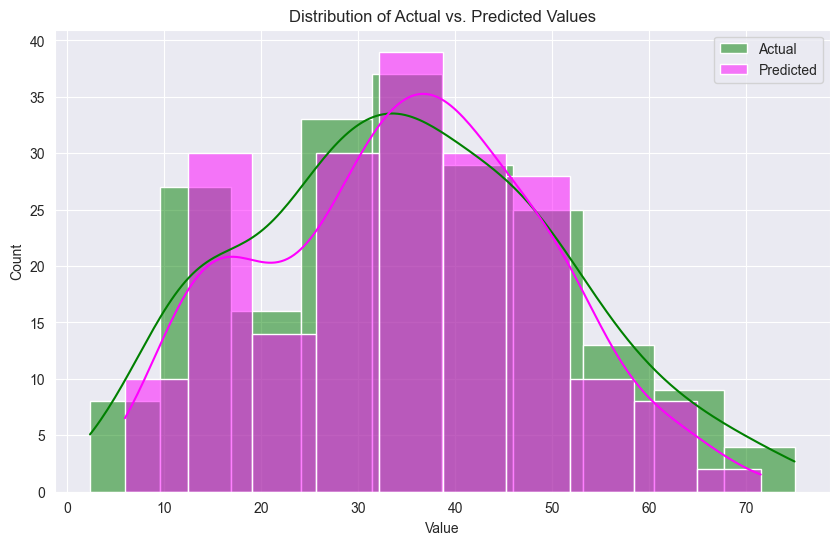

In [24]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor  # Importing RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Initialize the RandomForest model
model = RandomForestRegressor()

# Train the model on the training data
model.fit(X_train, Y_train)

# Make predictions on the training and test sets
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

# Calculate the metrics for the test set
r2_test = r2_score(Y_test, Y_pred_test)
mae_test = mean_absolute_error(Y_test, Y_pred_test)
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
mape_test = mean_absolute_percentage_error(Y_test, Y_pred_test)
accuracy_test = 100 - mape_test * 100 

# Evaluate the model on the training set
print("Training Set Metrics:")
print(f"R2 score: {r2_score(Y_train, Y_pred_train):.4f}")
print(f"MAE: {mean_absolute_error(Y_train, Y_pred_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_train, Y_pred_train)):.4f}")

# Evaluate the model on the test set
print("\nTest Set Metrics:")
print(f"R2 score: {r2_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"Accuracy: {accuracy_test:.2f}%")

# Scatter Plot for Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred_test, alpha=0.5, label='Predictions', color='purple')

# Ideal Prediction Line (y = x)
max_val = max(Y_test.max(), Y_pred_test.max())
min_val = min(Y_test.min(), Y_pred_test.min())
plt.plot([min_val, max_val], [min_val, max_val], '--', lw=2, color='black', label='Ideal Prediction (y = x)')

# Regression Line for Predictions
coefficients = np.polyfit(Y_test, Y_pred_test, 1)
regression_line = np.polyval(coefficients, Y_test)
plt.plot(Y_test, regression_line, color='orange', lw=2, 
         label=f'Regression Line: $y = {coefficients[0]:.4f}x + {coefficients[1]:.4f}$')

# Add R² value to the plot
plt.text(0.05, 0.85, f'$R^2 = {r2_test:.4f}$', transform=plt.gca().transAxes, fontsize=12)

# Labels and title
plt.xlabel('Experimental/Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model Validation: Predicted vs. Actual Values (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(Y_test, color='green', label='Actual', kde=True, alpha=0.5)
sns.histplot(Y_pred_test, color='magenta', label='Predicted', kde=True, alpha=0.5)
plt.xlabel('Value')
plt.title('Distribution of Actual vs. Predicted Values')
plt.legend()
plt.show()


### XGB

Training Set Metrics:
R2 score: 0.9925
MAE: 0.6109
RMSE: 1.3583

Test Set Metrics:
R2 score: 0.8906
MAE: 3.2664
RMSE: 5.2253
Accuracy: 89.23%


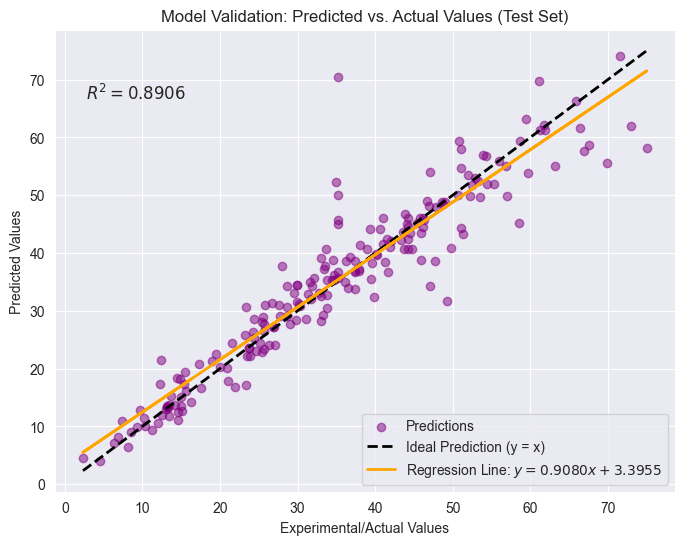

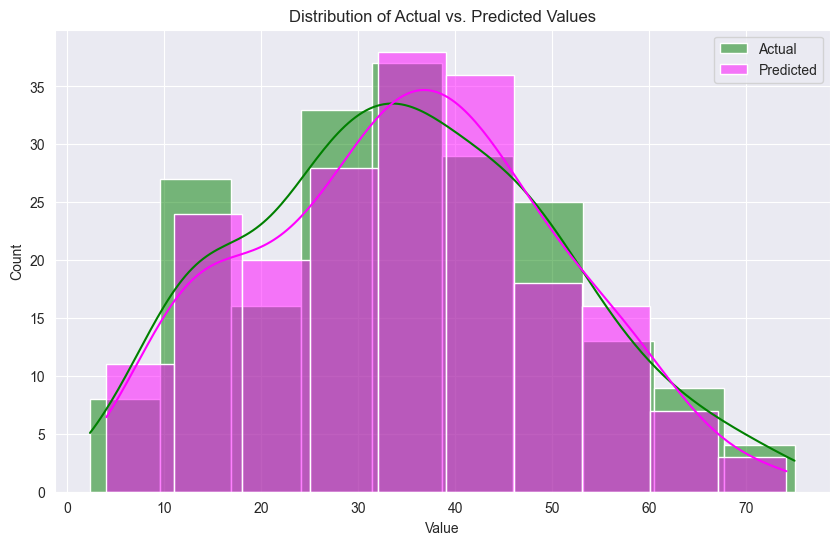

In [25]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from xgboost import XGBRegressor  # Importing XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Initialize the XGBoost model
model = XGBRegressor()

# Train the model on the training data
model.fit(X_train, Y_train)

# Make predictions on the training and test sets
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

# Calculate the metrics for the test set
r2_test = r2_score(Y_test, Y_pred_test)
mae_test = mean_absolute_error(Y_test, Y_pred_test)
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
mape_test = mean_absolute_percentage_error(Y_test, Y_pred_test)
accuracy_test = 100 - mape_test * 100 

# Evaluate the model on the training set
print("Training Set Metrics:")
print(f"R2 score: {r2_score(Y_train, Y_pred_train):.4f}")
print(f"MAE: {mean_absolute_error(Y_train, Y_pred_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_train, Y_pred_train)):.4f}")

# Evaluate the model on the test set
print("\nTest Set Metrics:")
print(f"R2 score: {r2_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"Accuracy: {accuracy_test:.2f}%")

# Scatter Plot for Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred_test, alpha=0.5, label='Predictions', color='purple')

# Ideal Prediction Line (y = x)
max_val = max(Y_test.max(), Y_pred_test.max())
min_val = min(Y_test.min(), Y_pred_test.min())
plt.plot([min_val, max_val], [min_val, max_val], '--', lw=2, color='black', label='Ideal Prediction (y = x)')

# Regression Line for Predictions
coefficients = np.polyfit(Y_test, Y_pred_test, 1)
regression_line = np.polyval(coefficients, Y_test)
plt.plot(Y_test, regression_line, color='orange', lw=2, 
         label=f'Regression Line: $y = {coefficients[0]:.4f}x + {coefficients[1]:.4f}$')

# Add R² value to the plot
plt.text(0.05, 0.85, f'$R^2 = {r2_test:.4f}$', transform=plt.gca().transAxes, fontsize=12)

# Labels and title
plt.xlabel('Experimental/Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model Validation: Predicted vs. Actual Values (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(Y_test, color='green', label='Actual', kde=True, alpha=0.5)
sns.histplot(Y_pred_test, color='magenta', label='Predicted', kde=True, alpha=0.5)
plt.xlabel('Value')
plt.title('Distribution of Actual vs. Predicted Values')
plt.legend()
plt.show()


### CATBOOST

0:	learn: 14.7305373	total: 148ms	remaining: 2m 28s
200:	learn: 3.3734431	total: 410ms	remaining: 1.63s
400:	learn: 2.4090262	total: 646ms	remaining: 965ms
600:	learn: 1.9740717	total: 880ms	remaining: 585ms
800:	learn: 1.7475211	total: 1.11s	remaining: 276ms
999:	learn: 1.6006259	total: 1.34s	remaining: 0us
Training Set Metrics:
R2 score: 0.9895
MAE: 0.9315
RMSE: 1.6006

Test Set Metrics:
R2 score: 0.8865
MAE: 2.9182
RMSE: 5.3235
Accuracy: 90.21%


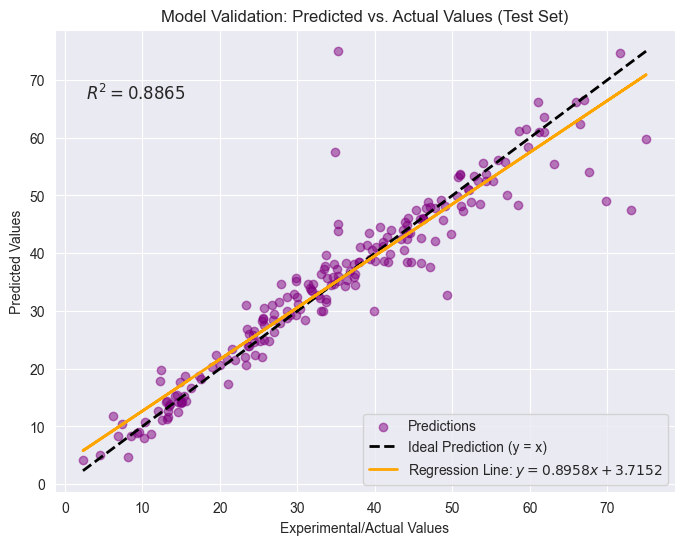

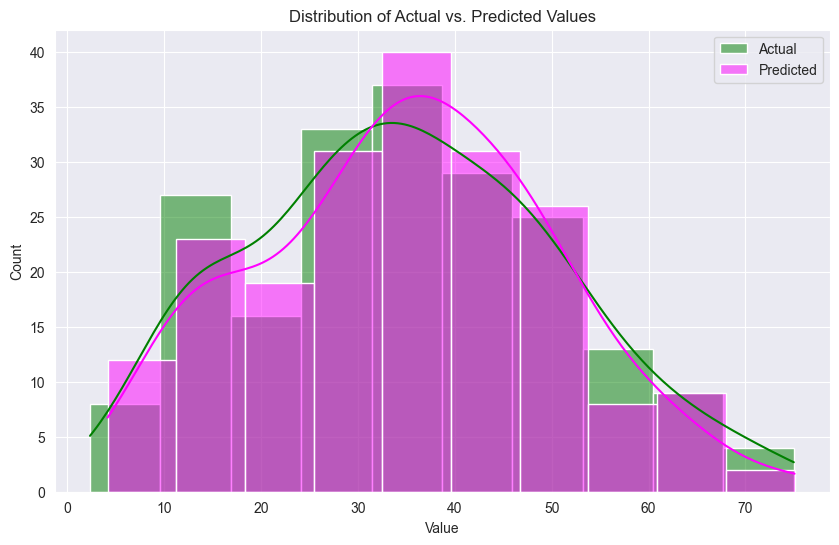

In [26]:
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from catboost import CatBoostRegressor  # Importing CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Initialize the CatBoost model
model = CatBoostRegressor(learning_rate=0.1, iterations=1000, depth=6, cat_features=[], verbose=200)

# Train the model on the training data
model.fit(X_train, Y_train)

# Make predictions on the training and test sets
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

# Calculate the metrics for the test set
r2_test = r2_score(Y_test, Y_pred_test)
mae_test = mean_absolute_error(Y_test, Y_pred_test)
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
mape_test = mean_absolute_percentage_error(Y_test, Y_pred_test)
accuracy_test = 100 - mape_test * 100 

# Evaluate the model on the training set
print("Training Set Metrics:")
print(f"R2 score: {r2_score(Y_train, Y_pred_train):.4f}")
print(f"MAE: {mean_absolute_error(Y_train, Y_pred_train):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_train, Y_pred_train)):.4f}")

# Evaluate the model on the test set
print("\nTest Set Metrics:")
print(f"R2 score: {r2_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"Accuracy: {accuracy_test:.2f}%")

# Scatter Plot for Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred_test, alpha=0.5, label='Predictions', color='purple')

# Ideal Prediction Line (y = x)
max_val = max(Y_test.max(), Y_pred_test.max())
min_val = min(Y_test.min(), Y_pred_test.min())
plt.plot([min_val, max_val], [min_val, max_val], '--', lw=2, color='black', label='Ideal Prediction (y = x)')

# Regression Line for Predictions
coefficients = np.polyfit(Y_test, Y_pred_test, 1)
regression_line = np.polyval(coefficients, Y_test)
plt.plot(Y_test, regression_line, color='orange', lw=2, 
         label=f'Regression Line: $y = {coefficients[0]:.4f}x + {coefficients[1]:.4f}$')

# Add R² value to the plot
plt.text(0.05, 0.85, f'$R^2 = {r2_test:.4f}$', transform=plt.gca().transAxes, fontsize=12)

# Labels and title
plt.xlabel('Experimental/Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model Validation: Predicted vs. Actual Values (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(Y_test, color='green', label='Actual', kde=True, alpha=0.5)
sns.histplot(Y_pred_test, color='magenta', label='Predicted', kde=True, alpha=0.5)
plt.xlabel('Value')
plt.title('Distribution of Actual vs. Predicted Values')
plt.legend()
plt.show()


## Using firefly algorithm
- The Firefly Algorithm is designed to minimize an objective function.
- R² score measures the goodness of fit, where higher is better.
- Since the Firefly Algorithm minimizes values, we take the negative of the R² score so that maximizing R² becomes equivalent to minimizing negative R².


Optimizing hyperparameters for LGBM...
Iteration 1/15, Best Test R² so far: -0.8741
Iteration 2/15, Best Test R² so far: -0.8744
Iteration 3/15, Best Test R² so far: -0.8751
Iteration 4/15, Best Test R² so far: -0.8780
Iteration 5/15, Best Test R² so far: -0.8780
Iteration 6/15, Best Test R² so far: -0.8780
Iteration 7/15, Best Test R² so far: -0.8780
Iteration 8/15, Best Test R² so far: -0.8780
Iteration 9/15, Best Test R² so far: -0.8780
Iteration 10/15, Best Test R² so far: -0.8780
Iteration 11/15, Best Test R² so far: -0.8780
Iteration 12/15, Best Test R² so far: -0.8783
Iteration 13/15, Best Test R² so far: -0.8783
Iteration 14/15, Best Test R² so far: -0.8783
Iteration 15/15, Best Test R² so far: -0.8783

Optimizing hyperparameters for RF...
Iteration 1/15, Best Test R² so far: -0.8156
Iteration 2/15, Best Test R² so far: -0.8156
Iteration 3/15, Best Test R² so far: -0.8156
Iteration 4/15, Best Test R² so far: -0.8156
Iteration 5/15, Best Test R² so far: -0.8156
Iteration 6/15, 

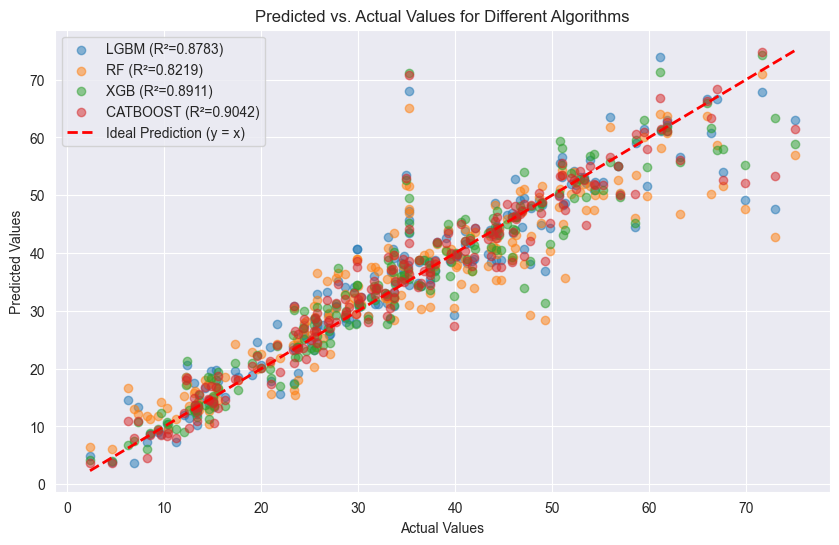

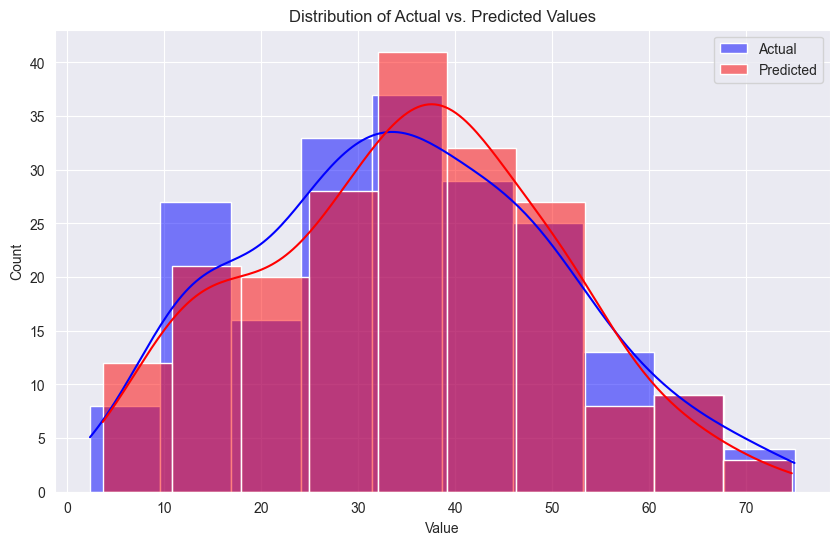

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR

# Objective function to minimize (Test R² Score)
def objective(params, algorithm='lgbm'):
    if algorithm == 'lgbm':
        n_estimators, max_depth, learning_rate = params
        model = LGBMRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            random_state=42,
        )
    elif algorithm == 'rf':
        n_estimators, max_depth = params
        model = RandomForestRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            random_state=42,
        )
    elif algorithm == 'xgb':
        n_estimators, max_depth, learning_rate = params
        model = XGBRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            random_state=42,
            verbosity=0
        )
    elif algorithm == 'catboost':
        n_estimators, learning_rate = params
        model = CatBoostRegressor(
            iterations=int(n_estimators),
            learning_rate=learning_rate,
            verbose=0,
            random_state=42,
        )
    else:
        raise ValueError("Unsupported algorithm")
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(Y_test, y_pred)
    return -r2  # Return negative R² to minimize

# Firefly Algorithm for hyperparameter optimization
def firefly_algorithm(objective_func, lb, ub, num_fireflies=20, max_iter=15, alpha=0.5, beta0=1, gamma=1):
    num_params = len(lb)
    fireflies = np.random.uniform(low=lb, high=ub, size=(num_fireflies, num_params))
    fitness = np.array([objective_func(f) for f in fireflies])
    
    for iteration in range(max_iter):
        for i in range(num_fireflies):
            for j in range(num_fireflies):
                if fitness[j] < fitness[i]:  # Move firefly i towards j if j is brighter
                    distance = np.linalg.norm(fireflies[i] - fireflies[j])
                    beta = beta0 * np.exp(-gamma * distance ** 2)
                    fireflies[i] = fireflies[i] + beta * (fireflies[j] - fireflies[i]) + alpha * (np.random.rand(num_params) - 0.5)
                    fireflies[i] = np.clip(fireflies[i], lb, ub)
                    fitness[i] = objective_func(fireflies[i])
                    
        alpha *= 0.9
        print(f"Iteration {iteration + 1}/{max_iter}, Best Test R² so far: {np.min(fitness):.4f}")
    
    best_index = np.argmin(fitness)
    return fireflies[best_index], -fitness[best_index]

# Define bounds for hyperparameters for each algorithm
bounds = {
    'lgbm': ([100, 3, 0.01], [1000, 10, 0.3]),
    'rf': ([100, 3], [1000, 10]),
    'xgb': ([100, 3, 0.01], [1000, 10, 0.3]),
    'catboost': ([100, 0.01], [1000, 0.3]),
}

# Container to hold results
results = {}

# Optimize hyperparameters for each algorithm using Firefly Algorithm
for algo in ['lgbm', 'rf', 'xgb', 'catboost']:
    lb, ub = bounds[algo]
    print(f"\nOptimizing hyperparameters for {algo.upper()}...")
    best_params, best_r2 = firefly_algorithm(lambda params: objective(params, algorithm=algo), lb, ub)
    results[algo] = {'best_params': best_params, 'best_test_r2': best_r2}

# Evaluate and print results
print("\nFinal Model Evaluation:")
for algo, result in results.items():
    best_params = result['best_params']
    test_r2 = result['best_test_r2']
    print(f"Algorithm: {algo.upper()}")
    print(f"  Best Hyperparameters: {np.round(best_params, 4)}")
    print(f"  Test R²:     {test_r2:.4f}\n")

# Determine the best algorithm based on Test R²
best_algo = max(results, key=lambda k: results[k]['best_test_r2'])
print(f"The best algorithm is {best_algo.upper()} with a Test R² of {results[best_algo]['best_test_r2']:.4f}")

# Plot results for each algorithm
plt.figure(figsize=(10, 6))

for algo, result in results.items():
    best_params = result['best_params']
    best_r2 = result['best_test_r2']
    
    if algo == 'lgbm':
        model = LGBMRegressor(
            n_estimators=int(best_params[0]),
            max_depth=int(best_params[1]),
            learning_rate=best_params[2],
            random_state=42,
        )
    elif algo == 'rf':
        model = RandomForestRegressor(
            n_estimators=int(best_params[0]),
            max_depth=int(best_params[1]),
            random_state=42,
        )
    elif algo == 'xgb':
        model = XGBRegressor(
            n_estimators=int(best_params[0]),
            max_depth=int(best_params[1]),
            learning_rate=best_params[2],
            random_state=42,
            verbosity=0
        )
    elif algo == 'catboost':
        model = CatBoostRegressor(
            iterations=int(best_params[0]),
            learning_rate=best_params[1],
            verbose=0,
            random_state=42,
        )

    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    plt.scatter(Y_test, y_pred, alpha=0.5, label=f'{algo.upper()} (R²={best_r2:.4f})')

max_val = max(Y_test.max(), y_pred.max())
min_val = min(Y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], '--', lw=2, color='red', label='Ideal Prediction (y = x)')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values for Different Algorithms')
plt.legend()
plt.grid(True)
plt.show()

# Plot distribution of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.histplot(Y_test, color='blue', label='Actual', kde=True, alpha=0.5)
sns.histplot(y_pred, color='red', label='Predicted', kde=True, alpha=0.5)
plt.xlabel('Value')
plt.title('Distribution of Actual vs. Predicted Values')
plt.legend()
plt.show()



## Using Ant colony


Optimizing LGBM...
Iteration 1/15, Best R²: 0.8735
Iteration 2/15, Best R²: 0.8776
Iteration 3/15, Best R²: 0.8690
Iteration 4/15, Best R²: 0.8724
Iteration 5/15, Best R²: 0.8716
Iteration 6/15, Best R²: 0.8720
Iteration 7/15, Best R²: 0.8755
Iteration 8/15, Best R²: 0.8739
Iteration 9/15, Best R²: 0.8713
Iteration 10/15, Best R²: 0.8699
Iteration 11/15, Best R²: 0.8709
Iteration 12/15, Best R²: 0.8720
Iteration 13/15, Best R²: 0.8708
Iteration 14/15, Best R²: 0.8729
Iteration 15/15, Best R²: 0.8719

Optimizing RF...
Iteration 1/15, Best R²: 0.8156
Iteration 2/15, Best R²: 0.8160
Iteration 3/15, Best R²: 0.8158
Iteration 4/15, Best R²: 0.8158
Iteration 5/15, Best R²: 0.8168
Iteration 6/15, Best R²: 0.8151
Iteration 7/15, Best R²: 0.8150
Iteration 8/15, Best R²: 0.8169
Iteration 9/15, Best R²: 0.8135
Iteration 10/15, Best R²: 0.8167
Iteration 11/15, Best R²: 0.8155
Iteration 12/15, Best R²: 0.8153
Iteration 13/15, Best R²: 0.8160
Iteration 14/15, Best R²: 0.8156
Iteration 15/15, Best R

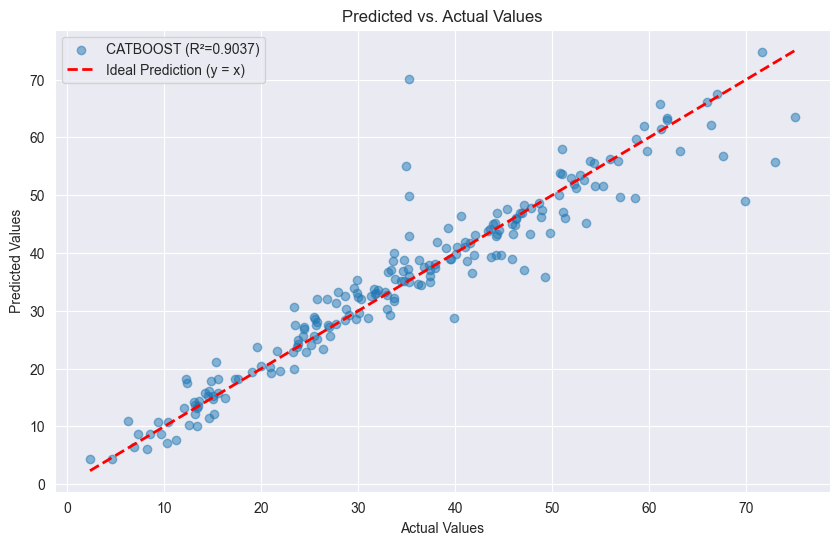

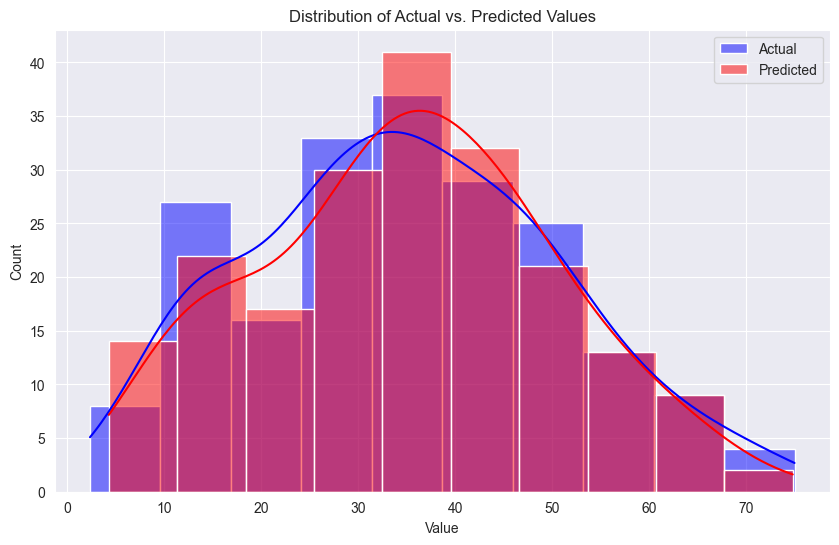

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


# Objective function to maximize R² score
def objective(params, algorithm='lgbm'):
    if algorithm == 'lgbm':
        n_estimators, max_depth, learning_rate = params
        model = LGBMRegressor(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    elif algorithm == 'rf':
        n_estimators, max_depth = params
        model = RandomForestRegressor(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
    elif algorithm == 'xgb':
        n_estimators, max_depth, learning_rate = params
        model = XGBRegressor(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    elif algorithm == 'catboost':
        n_estimators, learning_rate = params
        model = CatBoostRegressor(iterations=int(n_estimators), learning_rate=learning_rate, verbose=0, random_state=42)
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    return -r2_score(Y_test, y_pred)  # Convert R² to negative for minimization

# Define hyperparameter bounds
bounds = {
    'lgbm': ([100, 3, 0.01], [1000, 10, 0.3]),
    'rf': ([100, 3], [1000, 10]),
    'xgb': ([100, 3, 0.01], [1000, 10, 0.3]),
    'catboost': ([100, 0.01], [1000, 0.3]),
}

# ACO Hyperparameter Optimization
def aco(objective_func, lb, ub, num_ants=20, num_iterations=15):
    num_params = len(lb)
    pheromone = np.ones((num_params,))
    best_solution = None
    best_r2 = float('-inf')

    for iteration in range(num_iterations):
        solutions = []
        fitness = []

        for ant in range(num_ants):
            solution = [np.random.uniform(lb[i], ub[i]) for i in range(num_params)]
            r2 = objective_func(solution)
            solutions.append(solution)
            fitness.append(r2)

        # Sort solutions by highest R² (best first)
        sorted_indices = np.argsort(fitness)  
        solutions = [solutions[i] for i in sorted_indices]
        fitness = [fitness[i] for i in sorted_indices]

        # Update pheromone
        for i in range(num_params):
            pheromone[i] += 1.0 / (1.0 + np.abs(fitness[0]))

        pheromone *= 0.9  # Evaporation

        max_r2 = np.max([-r for r in fitness])
        if max_r2 > best_r2:
            best_r2 = max_r2
            best_solution = solutions[0]

        print(f"Iteration {iteration + 1}/{num_iterations}, Best R²: {-fitness[0]:.4f}")

    return best_solution, best_r2

# Optimize each algorithm
results = {}
for algo in ['lgbm', 'rf', 'xgb', 'catboost']:
    lb, ub = bounds[algo]
    print(f"\nOptimizing {algo.upper()}...")
    best_params, best_r2 = aco(lambda params: objective(params, algorithm=algo), lb, ub)
    results[algo] = {'best_params': best_params, 'best_test_r2': best_r2}

# Evaluate and print results
print("\nFinal Model Evaluation:")
for algo, result in results.items():
    best_params = result['best_params']
    test_r2 = result['best_test_r2']  # Fixed key reference
    print(f"Algorithm: {algo.upper()}")
    print(f"  Best Hyperparameters: {np.round(best_params, 4)}")
    print(f"  Test R²: {test_r2:.4f}\n")

# Select best model
best_algo = max(results, key=lambda k: results[k]['best_test_r2'])
print(f"The best algorithm is {best_algo.upper()} with R²: {results[best_algo]['best_test_r2']:.4f}")

# Train the best model
best_params = results[best_algo]['best_params']
if best_algo == 'lgbm':
    best_model = LGBMRegressor(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), learning_rate=best_params[2], random_state=42)
elif best_algo == 'rf':
    best_model = RandomForestRegressor(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), random_state=42)
elif best_algo == 'xgb':
    best_model = XGBRegressor(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), learning_rate=best_params[2], random_state=42)
elif best_algo == 'catboost':
    best_model = CatBoostRegressor(iterations=int(best_params[0]), learning_rate=best_params[1], verbose=0, random_state=42)

best_model.fit(X_train, Y_train)
y_pred = best_model.predict(X_test)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, alpha=0.5, label=f'{best_algo.upper()} (R²={results[best_algo]["best_test_r2"]:.4f})')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], '--', lw=2, color='red', label='Ideal Prediction (y = x)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

# Plot distribution of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.histplot(Y_test, color='blue', label='Actual', kde=True, alpha=0.5)
sns.histplot(y_pred, color='red', label='Predicted', kde=True, alpha=0.5)
plt.xlabel('Value')
plt.title('Distribution of Actual vs. Predicted Values')
plt.legend()
plt.show()


## using BEE algorithm


Optimizing hyperparameters for LGBM using Bee Algorithm...
Iteration 1/15, Best Test R² so far: 0.8722
Iteration 2/15, Best Test R² so far: 0.8736
Iteration 3/15, Best Test R² so far: 0.8742
Iteration 4/15, Best Test R² so far: 0.8742
Iteration 5/15, Best Test R² so far: 0.8742
Iteration 6/15, Best Test R² so far: 0.8742
Iteration 7/15, Best Test R² so far: 0.8745
Iteration 8/15, Best Test R² so far: 0.8746
Iteration 9/15, Best Test R² so far: 0.8746
Iteration 10/15, Best Test R² so far: 0.8747
Iteration 11/15, Best Test R² so far: 0.8755
Iteration 12/15, Best Test R² so far: 0.8784
Iteration 13/15, Best Test R² so far: 0.8784
Iteration 14/15, Best Test R² so far: 0.8784
Iteration 15/15, Best Test R² so far: 0.8784

Optimizing hyperparameters for RF using Bee Algorithm...
Iteration 1/15, Best Test R² so far: 0.8158
Iteration 2/15, Best Test R² so far: 0.8158
Iteration 3/15, Best Test R² so far: 0.8214
Iteration 4/15, Best Test R² so far: 0.8214
Iteration 5/15, Best Test R² so far: 0.8

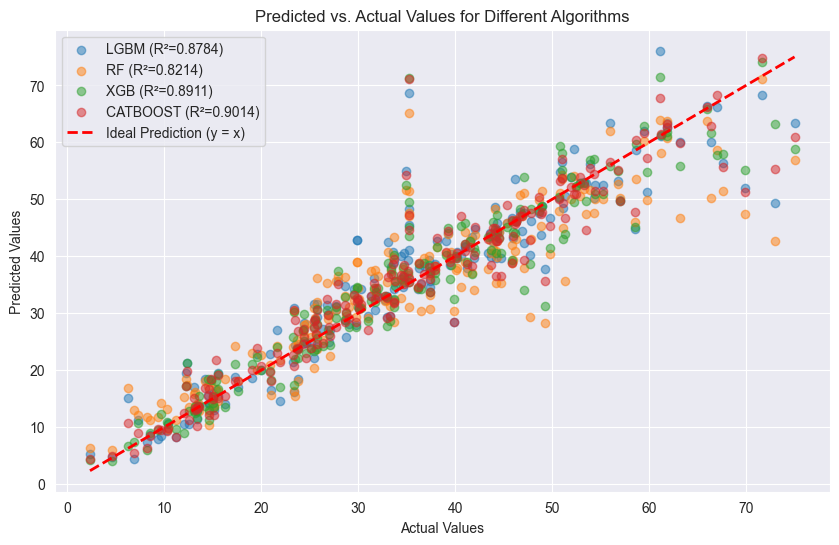

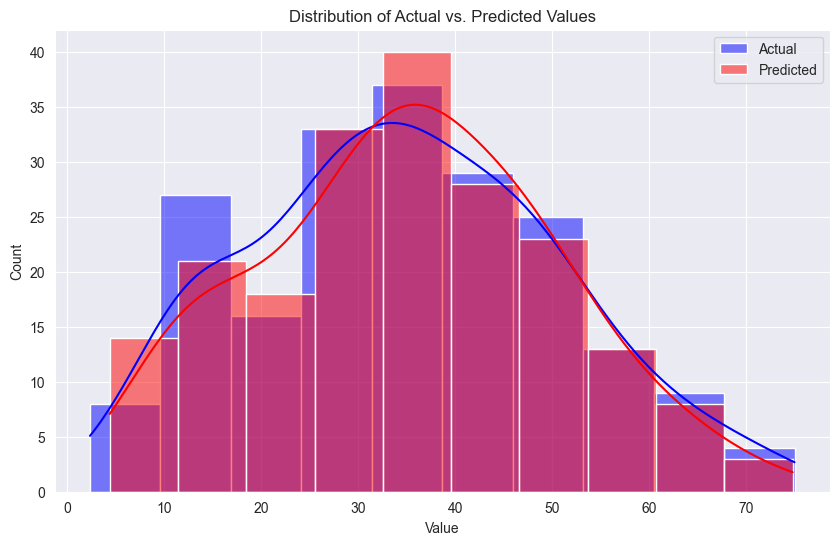

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR


# Objective function to maximize (Test R² score)
def objective(params, algorithm='lgbm'):
    # Create model based on algorithm and parameters
    if algorithm == 'lgbm':
        n_estimators, max_depth, learning_rate = params
        model = LGBMRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            random_state=42,
        )
    elif algorithm == 'rf':
        n_estimators, max_depth = params
        model = RandomForestRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            random_state=42,
        )
    elif algorithm == 'xgb':
        n_estimators, max_depth, learning_rate = params
        model = XGBRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            random_state=42,
            verbosity=0
        )
    elif algorithm == 'catboost':
        n_estimators, learning_rate = params
        model = CatBoostRegressor(
            iterations=int(n_estimators),
            learning_rate=learning_rate,
            verbose=0,
            random_state=42,
        )
    else:
        raise ValueError("Unsupported algorithm")
    
    # Fit the model on training data
    model.fit(X_train, Y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    
    # Calculate R² score
    r2 = r2_score(Y_test, y_pred)
    
    # Return the negative R² score to minimize (since we want to maximize R²)
    return -r2  # Negative to maximize R²

# Bee Algorithm for hyperparameter optimization
def bee_algorithm(objective_func, lb, ub, num_bees=20, max_iter=15, num_best=5, patch_size=0.1, num_recruited=5):
    num_params = len(lb)
    bees = np.random.uniform(low=lb, high=ub, size=(num_bees, num_params))
    fitness = np.array([objective_func(bee) for bee in bees])
    current_patch_size = patch_size

    for iteration in range(max_iter):
        sorted_indices = np.argsort(fitness)
        bees = bees[sorted_indices]
        fitness = fitness[sorted_indices]
        
        new_bees = []
        new_fitness = []
        for i in range(num_best):
            best_bee = bees[i]
            best_bee_fitness = fitness[i]
            for _ in range(num_recruited):
                candidate = best_bee + current_patch_size * np.random.uniform(-1, 1, num_params)
                candidate = np.clip(candidate, lb, ub)
                candidate_fitness = objective_func(candidate)
                if candidate_fitness < best_bee_fitness:
                    best_bee = candidate
                    best_bee_fitness = candidate_fitness
            new_bees.append(best_bee)
            new_fitness.append(best_bee_fitness)
        
        remaining = num_bees - len(new_bees)
        scouts = np.random.uniform(low=lb, high=ub, size=(remaining, num_params))
        scouts_fitness = np.array([objective_func(bee) for bee in scouts])
        
        bees = np.vstack([np.array(new_bees), scouts])
        fitness = np.concatenate([np.array(new_fitness), scouts_fitness])
        
        current_patch_size *= 0.95
        
        print(f"Iteration {iteration + 1}/{max_iter}, Best Test R² so far: {-np.min(fitness):.4f}")
    
    best_index = np.argmin(fitness)
    return bees[best_index], fitness[best_index]

# Define bounds for hyperparameters for each algorithm
bounds = {
    'lgbm': ([100, 3, 0.01], [1000, 10, 0.3]),
    'rf': ([100, 3], [1000, 10]),
    'xgb': ([100, 3, 0.01], [1000, 10, 0.3]),
    'catboost': ([100, 0.01], [1000, 0.3]),
}

# Container to hold the results
results = {}

# Optimize hyperparameters for each algorithm using the Bee Algorithm
for algo in ['lgbm', 'rf', 'xgb', 'catboost']:
    lb, ub = bounds[algo]
    print(f"\nOptimizing hyperparameters for {algo.upper()} using Bee Algorithm...")
    best_params, best_r2 = bee_algorithm(lambda params: objective(params, algorithm=algo), lb, ub)
    results[algo] = {'best_params': best_params, 'best_test_r2': -best_r2}  # Store positive R²

# Function to create and evaluate model given best parameters
def evaluate_model(algorithm, params):
    if algorithm == 'lgbm':
        n_estimators, max_depth, learning_rate = params
        model = LGBMRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            random_state=42,
        )
    elif algorithm == 'rf':
        n_estimators, max_depth = params
        model = RandomForestRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            random_state=42,
        )
    elif algorithm == 'xgb':
        n_estimators, max_depth, learning_rate = params
        model = XGBRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            random_state=42,
            verbosity=0
        )
    elif algorithm == 'catboost':
        n_estimators, learning_rate = params
        model = CatBoostRegressor(
            iterations=int(n_estimators),
            learning_rate=learning_rate,
            verbose=0,
            random_state=42,
        )
    else:
        raise ValueError("Unsupported algorithm")
    
    # Fit the model on the training data
    model.fit(X_train, Y_train)
    
    # Predict on both training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_r2 = r2_score(Y_train, y_train_pred)
    test_r2 = r2_score(Y_test, y_test_pred)
    
    return train_r2, test_r2

# Evaluate and print detailed results for each algorithm
print("\nFinal Model Evaluation:")
for algo, result in results.items():
    best_params = result['best_params']
    test_r2 = result['best_test_r2']
    train_r2, test_r2_eval = evaluate_model(algo, best_params)
    print(f"Algorithm: {algo.upper()}")
    print(f"  Best Hyperparameters: {np.round(best_params, 4)}")
    print(f"  Training R² Score (Accuracy): {train_r2:.4f}")
    print(f"  Test R² Score (Accuracy):     {test_r2_eval:.4f}\n")
    results[algo].update({'train_r2': train_r2, 'test_r2': test_r2_eval})

# Determine the best algorithm based on Test R²
best_algo = max(results, key=lambda k: results[k]['test_r2'])
print(f"The best algorithm is {best_algo.upper()} with a Test R² of {results[best_algo]['test_r2']:.4f}")

# Plot results for each algorithm
plt.figure(figsize=(10, 6))

for algo, result in results.items():
    best_params = result['best_params']
    best_r2 = result['test_r2']
    
    if algo == 'lgbm':
        model = LGBMRegressor(
            n_estimators=int(best_params[0]),
            max_depth=int(best_params[1]),
            learning_rate=best_params[2],
            random_state=42,
        )
    elif algo == 'rf':
        model = RandomForestRegressor(
            n_estimators=int(best_params[0]),
            max_depth=int(best_params[1]),
            random_state=42,
        )
    elif algo == 'xgb':
        model = XGBRegressor(
            n_estimators=int(best_params[0]),
            max_depth=int(best_params[1]),
            learning_rate=best_params[2],
            random_state=42,
            verbosity=0
        )
    elif algo == 'catboost':
        model = CatBoostRegressor(
            iterations=int(best_params[0]),
            learning_rate=best_params[1],
            verbose=0,
            random_state=42,
        )

    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    plt.scatter(Y_test, y_pred, alpha=0.5, label=f'{algo.upper()} (R²={best_r2:.4f})')

max_val = max(Y_test.max(), y_pred.max())
min_val = min(Y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], '--', lw=2, color='red', label='Ideal Prediction (y = x)')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values for Different Algorithms')
plt.legend()
plt.grid(True)
plt.show()

# Plot distribution of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.histplot(Y_test, color='blue', label='Actual', kde=True, alpha=0.5)
sns.histplot(y_pred, color='red', label='Predicted', kde=True, alpha=0.5)
plt.xlabel('Value')
plt.title('Distribution of Actual vs. Predicted Values')
plt.legend()
plt.show()


## Using PSO


Optimizing hyperparameters for LGBM using Bee Algorithm...
Stopping search: maximum iterations reached --> 15

Optimizing hyperparameters for RF using Bee Algorithm...
Stopping search: maximum iterations reached --> 15

Optimizing hyperparameters for XGB using Bee Algorithm...
Stopping search: maximum iterations reached --> 15

Optimizing hyperparameters for CATBOOST using Bee Algorithm...
Stopping search: maximum iterations reached --> 15

Final Model Evaluation:
Algorithm: LGBM
  Best Hyperparameters: [6.392527e+02 6.781400e+00 1.219000e-01]
  Training R² Score: 0.9829
  Test R² Score:     0.8762

Algorithm: RF
  Best Hyperparameters: [116.4648  10.    ]
  Training R² Score: 0.9630
  Test R² Score:     0.8235

Algorithm: XGB
  Best Hyperparameters: [292.6262   6.1995   0.2973]
  Training R² Score: 0.9939
  Test R² Score:     0.8926

Algorithm: CATBOOST
  Best Hyperparameters: [5.770765e+02 2.194000e-01]
  Training R² Score: 0.9913
  Test R² Score:     0.8989

The best algorithm is C

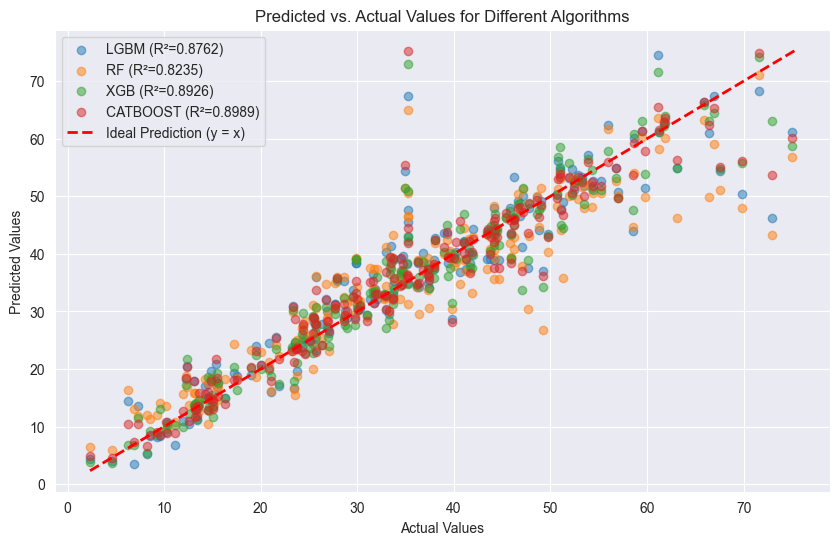

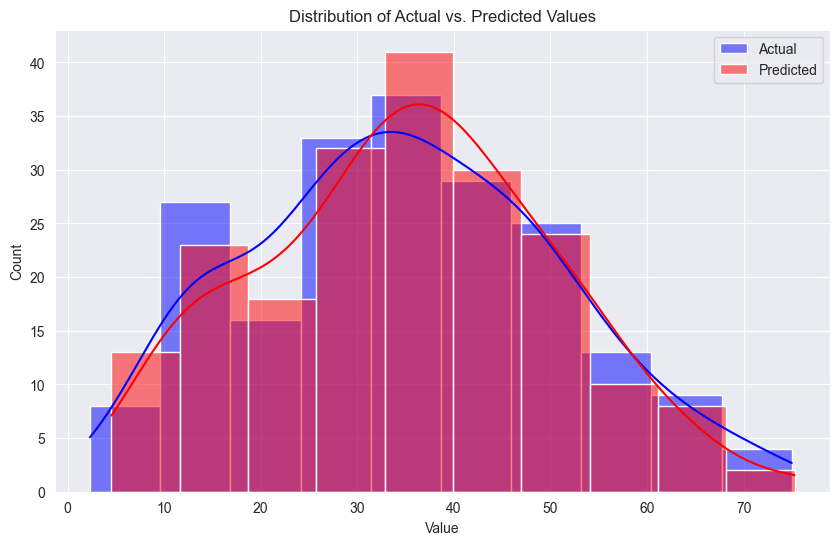

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns


# Objective function to maximize R² score
def objective(params, algorithm='lgbm'):
    if algorithm == 'lgbm':
        n_estimators, max_depth, learning_rate = params
        model = LGBMRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            random_state=42,
        )
    elif algorithm == 'rf':
        n_estimators, max_depth = params
        model = RandomForestRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            random_state=42,
        )
    elif algorithm == 'xgb':
        n_estimators, max_depth, learning_rate = params
        model = XGBRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            random_state=42,
            verbosity=0
        )
    elif algorithm == 'catboost':
        n_estimators, learning_rate = params
        model = CatBoostRegressor(
            iterations=int(n_estimators),
            learning_rate=learning_rate,
            verbose=0,
            random_state=42,
        )
    elif algorithm == 'svr':
        c, epsilon = params
        model = SVR(C=c, epsilon=epsilon)
    else:
        raise ValueError("Unsupported algorithm")
    
    # Fit the model on the training data
    model.fit(X_train, Y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Calculate R² score
    r2 = r2_score(Y_test, y_pred)
    
    # Return negative R² score to maximize (since PSO minimizes the objective)
    return -r2

# Define bounds for hyperparameters for each algorithm
bounds = {
    'lgbm': ([100, 3, 0.01], [1000, 10, 0.3]),
    'rf': ([100, 3], [1000, 10]),
    'xgb': ([100, 3, 0.01], [1000, 10, 0.3]),
    'catboost': ([100, 0.01], [1000, 0.3]),  # iterations and learning_rate
}

# Container to hold the results
results = {}

# Run PSO for each algorithm (assuming pso function is defined)
for algo in ['lgbm', 'rf', 'xgb', 'catboost']:
    lb, ub = bounds[algo]
    print(f"\nOptimizing hyperparameters for {algo.upper()} using Bee Algorithm...")
    # Assuming pso is a predefined function for Particle Swarm Optimization
    best_params, best_neg_r2 = pso(lambda params: objective(params, algorithm=algo), lb, ub, swarmsize=10, maxiter=15)
    results[algo] = {'best_params': best_params, 'best_test_r2': -best_neg_r2} 

# Function to create, train, and evaluate model given best parameters
def evaluate_model(algorithm, params):
    if algorithm == 'lgbm':
        n_estimators, max_depth, learning_rate = params
        model = LGBMRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            random_state=42,
        )
    elif algorithm == 'rf':
        n_estimators, max_depth = params
        model = RandomForestRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            random_state=42,
        )
    elif algorithm == 'xgb':
        n_estimators, max_depth, learning_rate = params
        model = XGBRegressor(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            random_state=42,
            verbosity=0
        )
    elif algorithm == 'catboost':
        n_estimators, learning_rate = params
        model = CatBoostRegressor(
            iterations=int(n_estimators),
            learning_rate=learning_rate,
            verbose=0,
            random_state=42,
        )

    else:
        raise ValueError("Unsupported algorithm")
    
    # Fit the model on the training data
    model.fit(X_train, Y_train)
    
    # Predict on both training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_r2 = r2_score(Y_train, y_train_pred)
    test_r2 = r2_score(Y_test, y_test_pred)
    
    return train_r2, test_r2

# Final Model Evaluation Output Format
print("\nFinal Model Evaluation:")
for algo, result in results.items():
    best_params = result['best_params']
    # Evaluate the model using the best parameters found by PSO
    train_r2, test_r2_eval = evaluate_model(algo, best_params)
    print(f"Algorithm: {algo.upper()}")
    print(f"  Best Hyperparameters: {np.round(best_params, 4)}")
    print(f"  Training R² Score: {train_r2:.4f}")
    print(f"  Test R² Score:     {test_r2_eval:.4f}\n")
    # Update results dictionary
    results[algo].update({
        'train_r2': train_r2, 
        'test_r2': test_r2_eval,
    })

# Determine the best algorithm based on Test R²
best_algo = max(results, key=lambda k: results[k]['test_r2'])
print(f"The best algorithm is {best_algo.upper()} with a Test R² of {results[best_algo]['test_r2']:.4f}")

# Plot results for each algorithm
plt.figure(figsize=(10, 6))

for algo, result in results.items():
    best_params = result['best_params']
    best_r2 = result['test_r2']
    
    if algo == 'lgbm':
        model = LGBMRegressor(
            n_estimators=int(best_params[0]),
            max_depth=int(best_params[1]),
            learning_rate=best_params[2],
            random_state=42,
        )
    elif algo == 'rf':
        model = RandomForestRegressor(
            n_estimators=int(best_params[0]),
            max_depth=int(best_params[1]),
            random_state=42,
        )
    elif algo == 'xgb':
        model = XGBRegressor(
            n_estimators=int(best_params[0]),
            max_depth=int(best_params[1]),
            learning_rate=best_params[2],
            random_state=42,
            verbosity=0
        )
    elif algo == 'catboost':
        model = CatBoostRegressor(
            iterations=int(best_params[0]),
            learning_rate=best_params[1],
            verbose=0,
            random_state=42,
        )
 
    
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    plt.scatter(Y_test, y_pred, alpha=0.5, label=f'{algo.upper()} (R²={best_r2:.4f})')

max_val = max(Y_test.max(), y_pred.max())
min_val = min(Y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], '--', lw=2, color='red', label='Ideal Prediction (y = x)')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values for Different Algorithms')
plt.legend()
plt.grid(True)
plt.show()

# Plot distribution of actual vs predicted values
plt.figure(figsize=(10, 6))
sns.histplot(Y_test, color='blue', label='Actual', kde=True, alpha=0.5)
sns.histplot(y_pred, color='red', label='Predicted', kde=True, alpha=0.5)
plt.xlabel('Value')
plt.title('Distribution of Actual vs. Predicted Values')
plt.legend()
plt.show()


## Using BBO Algorithm

LGBM - Generation 1/15, Best R²: 0.8745
LGBM - Generation 2/15, Best R²: 0.8745
LGBM - Generation 3/15, Best R²: 0.8745
LGBM - Generation 4/15, Best R²: 0.8745
LGBM - Generation 5/15, Best R²: 0.8745
LGBM - Generation 6/15, Best R²: 0.8745
LGBM - Generation 7/15, Best R²: 0.8745
LGBM - Generation 8/15, Best R²: 0.8745
LGBM - Generation 9/15, Best R²: 0.8745
LGBM - Generation 10/15, Best R²: 0.8745
LGBM - Generation 11/15, Best R²: 0.8745
LGBM - Generation 12/15, Best R²: 0.8745
LGBM - Generation 13/15, Best R²: 0.8745
LGBM - Generation 14/15, Best R²: 0.8745
LGBM - Generation 15/15, Best R²: 0.8745
RF - Generation 1/15, Best R²: 0.8166
RF - Generation 2/15, Best R²: 0.8166
RF - Generation 3/15, Best R²: 0.8168
RF - Generation 4/15, Best R²: 0.8168
RF - Generation 5/15, Best R²: 0.8168
RF - Generation 6/15, Best R²: 0.8168
RF - Generation 7/15, Best R²: 0.8168
RF - Generation 8/15, Best R²: 0.8168
RF - Generation 9/15, Best R²: 0.8168
RF - Generation 10/15, Best R²: 0.8168
RF - Generati

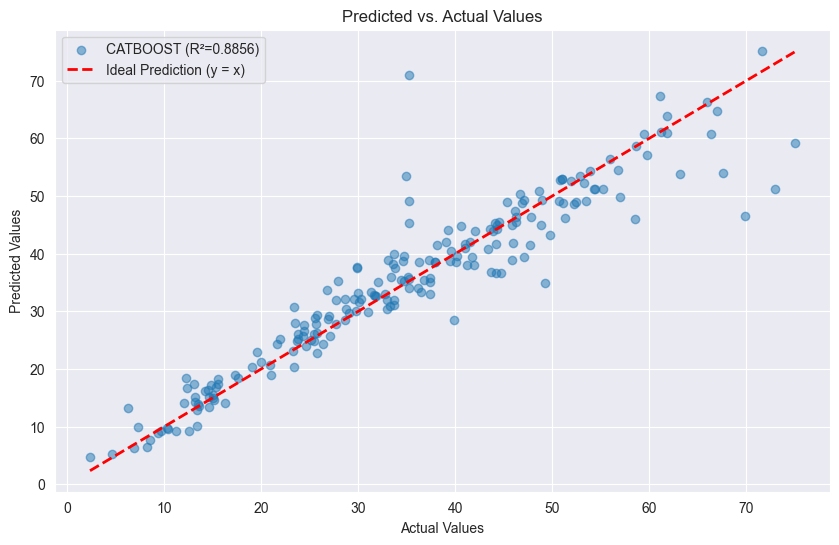

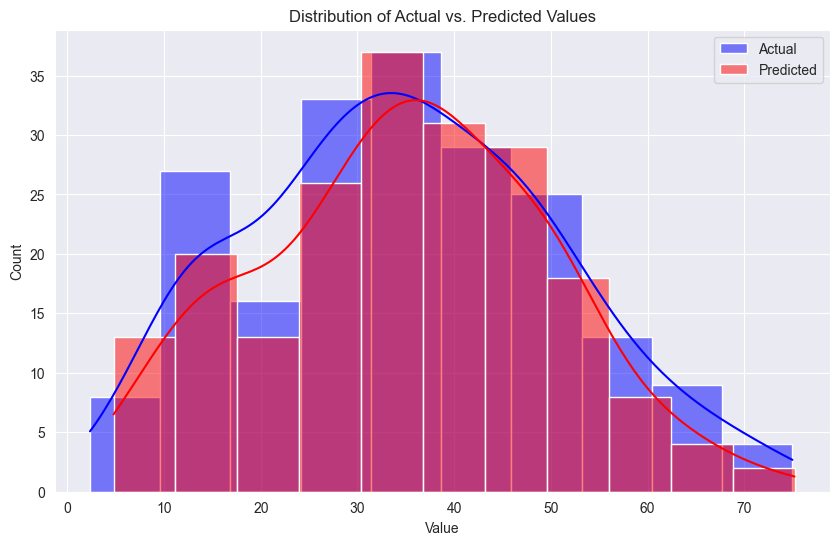

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor



# Objective function to maximize R² score
def objective(params, algorithm='lgbm'):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    learning_rate = params[2] if algorithm in ['lgbm', 'xgb', 'catboost'] else None

    if algorithm == 'lgbm':
        model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    elif algorithm == 'rf':
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif algorithm == 'xgb':
        model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    elif algorithm == 'catboost':
        model = CatBoostRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            verbose=0,
            random_state=42,
            bootstrap_type='Bayesian'  # ✅ Removed `subsample`
        )

    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    return -r2_score(Y_test, y_pred)  # Convert R² to negative for minimization

# Define hyperparameter bounds
bounds = {
    'lgbm': ([100, 3, 0.01], [1000, 10, 0.3]),
    'rf': ([100, 3], [1000, 10]),
    'xgb': ([100, 3, 0.01], [1000, 10, 0.3]),
    'catboost': ([100, 3, 0.01], [1000, 10, 0.3]),
}

# BBO Algorithm parameters
num_generations = 15
population_size = 20

results = {}
for algo in bounds.keys():
    lb, ub = bounds[algo]
    num_params = len(lb)
    population = np.random.uniform(low=lb, high=ub, size=(population_size, num_params))
    best_solution = None
    best_r2 = float('-inf')

    for generation in range(num_generations):
        fitness = np.array([objective(ind, algorithm=algo) for ind in population])

        min_r2 = -np.min(fitness)  # Convert from negative to positive R²
        if min_r2 > best_r2:
            best_r2 = min_r2
            best_solution = population[np.argmin(fitness)]

        # Migration Step
        for i in range(population_size):
            if np.random.rand() < 0.5:
                donor = population[np.random.randint(0, population_size)]
                population[i] = np.clip(population[i] + np.random.rand() * (donor - population[i]), lb, ub)

        # Mutation Step
        mutation_rate = 0.1
        for i in range(population_size):
            if np.random.rand() < mutation_rate:
                population[i] = np.clip(population[i] + np.random.normal(0, 0.1, size=num_params), lb, ub)

        print(f"{algo.upper()} - Generation {generation + 1}/{num_generations}, Best R²: {best_r2:.4f}")

    results[algo] = {'best_params': best_solution, 'best_r2': best_r2}

# Define model evaluation function
def evaluate_model(algorithm, params):
    n_estimators = int(params[0])
    max_depth = int(params[1])
    learning_rate = params[2] if algorithm in ['lgbm', 'xgb', 'catboost'] else None

    if algorithm == 'lgbm':
        model = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    elif algorithm == 'rf':
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif algorithm == 'xgb':
        model = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, random_state=42)
    elif algorithm == 'catboost':
        model = CatBoostRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            verbose=0,
            random_state=42,
            bootstrap_type='Bayesian'
        )

    model.fit(X_train, Y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(Y_train, y_train_pred)
    test_r2 = r2_score(Y_test, y_test_pred)

    return train_r2, test_r2

# Final Model Evaluation
print("\nFinal Model Evaluation:")
for algo, result in results.items():
    best_params = result['best_params']
    train_r2, test_r2_eval = evaluate_model(algo, best_params)
    print(f"Algorithm: {algo.upper()}")
    print(f"  Best Hyperparameters: {np.round(best_params, 4)}")
    print(f"  Training R² Score: {train_r2:.4f}")
    print(f"  Test R² Score:     {test_r2_eval:.4f}\n")
    results[algo].update({'train_r2': train_r2, 'test_r2': test_r2_eval})

# Select best model
best_algo = max(results, key=lambda k: results[k]['test_r2'])
print(f"The best algorithm is {best_algo.upper()} with a Test R² of {results[best_algo]['test_r2']:.4f}")

# Train best model and plot results
best_params = results[best_algo]['best_params']
if best_algo == 'lgbm':
    best_model = LGBMRegressor(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), learning_rate=best_params[2], random_state=42)
elif best_algo == 'rf':
    best_model = RandomForestRegressor(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), random_state=42)
elif best_algo == 'xgb':
    best_model = XGBRegressor(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), learning_rate=best_params[2], random_state=42)
elif best_algo == 'catboost':
    best_model = CatBoostRegressor(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), learning_rate=best_params[2], verbose=0, random_state=42, bootstrap_type='Bayesian')

best_model.fit(X_train, Y_train)
y_pred = best_model.predict(X_test)

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, y_pred, alpha=0.5, label=f'{best_algo.upper()} (R²={results[best_algo]["test_r2"]:.4f})')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], '--', lw=2, color='red', label='Ideal Prediction (y = x)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.grid(True)
plt.show()

# Histogram Plot
plt.figure(figsize=(10, 6))
sns.histplot(Y_test, color='blue', label='Actual', kde=True, alpha=0.5)
sns.histplot(y_pred, color='red', label='Predicted', kde=True, alpha=0.5)
plt.xlabel('Value')
plt.title('Distribution of Actual vs. Predicted Values')
plt.legend()
plt.show()
